In [1]:
import urllib.request
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data'

urllib.request.urlretrieve(url, 'car.data')

('car.data', <http.client.HTTPMessage at 0x7f108548c3d0>)

In [2]:
import numpy as np
data = np.loadtxt('car.data', dtype='str', delimiter=',')
X, y = data[:,:-1], data[:,-1]
X.shape, y.shape

((1728, 6), (1728,))

In [3]:
combinacoes = 1
for i in range(X.shape[1]):
    valores = set(X[:,i])
    combinacoes *= len(valores)
    print(valores)
print(combinacoes)

{'vhigh', 'low', 'med', 'high'}
{'vhigh', 'low', 'med', 'high'}
{'4', '2', '3', '5more'}
{'4', '2', 'more'}
{'big', 'small', 'med'}
{'high', 'low', 'med'}
1728


In [4]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ZeroR():
    def fit(self, X, y):
        self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]), dtype='<U5')
        y[:] = self.resposta
        return y

modelo = ZeroR()
modelo.fit(X,y)
ypred = modelo.predict(X)

accuracy_score(y, ypred), (ypred == y)


(0.7002314814814815, array([ True,  True,  True, ...,  True, False, False]))

In [5]:
def impureza(y): #Gini
    labels = list(set(y))
    labels.sort()
    probabilidades = np.zeros((len(labels),))
    for i, k in enumerate(labels):
        probabilidades[i] = sum(y==k)/len(y)
    result = 1 - sum(probabilidades**2)
    return result

ytmp = y[:]
valor = impureza(ytmp)
valor

0.457283763074417

In [6]:
def impurezaValor(x, y, valor):
    iguais = x==valor
    impurezaIguais = impureza(y[iguais])
    propIguais = sum(iguais)/len(y)
    impurezaDiferentes = impureza(y[~iguais])
    propDiferentes = sum(~iguais)/len(y)
    impurezaTotal = propIguais*impurezaIguais + propDiferentes*impurezaDiferentes
    return impurezaTotal

impurezaValor(X[:,0], y, 'vhigh')


0.44934645776177407

In [7]:
def impurezaMinima(X, y):
    impurezas = []
    caracteristicasValores = []
    for i in range(X.shape[1]):
        valores = sorted(list(set(X[:,i])))
        for valor in valores:
            caracteristicasValores.append([i,valor])
            impurezaValorCaracteristica = impurezaValor(X[:,i], y, valor)
            impurezas.append(impurezaValorCaracteristica)

    caracteristicasValores = np.array(caracteristicasValores)
    impurezas = np.array(impurezas)
    menorImpureza = np.argmin(impurezas)
    caracteristica, valor = caracteristicasValores[menorImpureza]
    return impurezas[menorImpureza], int(caracteristica), valor

impurezaMinima(X,y)


(0.38615712609310704, 3, '2')

In [8]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.impureza, self.caracteristica, self.valor = impurezaMinima(X,y)
        iguais = X[:,self.caracteristica] == self.valor
        if sum(iguais>0) and sum(~iguais)>0:
            self.iguais = Arvore()
            self.iguais.fit(X[iguais,:],y[iguais])
            self.diferentes = Arvore()
            self.diferentes.fit(X[~iguais,:],y[~iguais])
        else:
            self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]), dtype='<U5')
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            iguais = X[:,self.caracteristica] == self.valor
            y[iguais] = self.iguais.predict(X[iguais,:])
            y[~iguais] = self.diferentes.predict(X[~iguais,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)

accuracy_score(y, ypred), (ypred == y)

(1.0, array([ True,  True,  True, ...,  True,  True,  True]))

In [9]:
from sklearn.model_selection import cross_validate

scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.62716763, 0.73121387, 0.75144509, 0.75362319, 0.8057971 ]),
 0.7338493758900897)

## Árvore para atributos contínuos

In [10]:
from sklearn.datasets import load_iris
iris = load_iris()
X, y = iris.data[:,2:], iris.target


In [11]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class ZeroR():
    def fit(self, X, y):
        self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]))
        y[:] = self.resposta
        return y

modelo = ZeroR()
modelo.fit(X,y)
ypred = modelo.predict(X)

accuracy_score(y, ypred), (ypred == y)

(0.3333333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,

In [12]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.caracteristica = 0
    def fit(self, X, y):
        self.valor = np.mean(X[:,self.caracteristica])
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores>0) and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)

accuracy_score(y, ypred), (ypred == y)

(0.9533333333333334,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

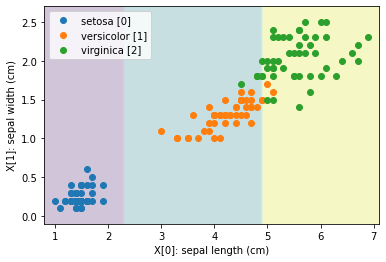

In [13]:
import matplotlib.pyplot as plt

def plotDecisao(modelo, X, y):
    modelo.fit(X, y)
    x0s = np.linspace(np.min(X[:,0])-0.2, np.max(X[:,0])+0.2, 100)
    x1s = np.linspace(np.min(X[:,1])-0.2, np.max(X[:,1])+0.2, 100)

    x0, x1 = np.meshgrid(x0s, x1s)
    Xdec = np.c_[x0.ravel(), x1.ravel()]

    ypred = modelo.predict(Xdec)
    plt.contourf(x0, x1, ypred.reshape(x0.shape), alpha=0.25)
    for k in set(y):
        plt.plot(X[:,0][y==k], X[:,1][y==k], 'o', label=f"{iris.target_names[k]} [{k}]")
    plt.xlabel(f"X[0]: {iris.feature_names[0]}")
    plt.ylabel(f"X[1]: {iris.feature_names[1]}")
    plt.legend()
    plt.show()

plotDecisao(Arvore(), X, y)

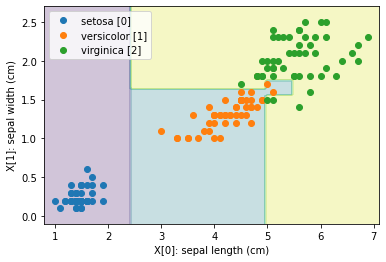

In [14]:
from sklearn.tree import DecisionTreeClassifier
plotDecisao(DecisionTreeClassifier(), X, y)

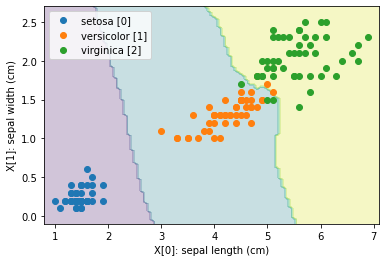

In [15]:
from sklearn.neighbors import KNeighborsClassifier
plotDecisao(KNeighborsClassifier(), X, y)

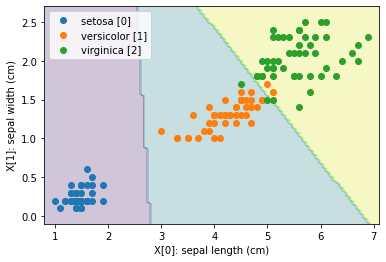

In [16]:
from sklearn.linear_model import LogisticRegression
plotDecisao(LogisticRegression(),X ,y)

In [17]:
def impurezaValor(x, y, valor):
    maiores = x>valor
    impurezaMaiores = impureza(y[maiores])
    propMaiores = sum(maiores)/len(y)
    impurezaMenores = impureza(y[~maiores])
    propMenores = sum(~maiores)/len(y)
    impurezaTotal = propMaiores*impurezaMaiores + propMenores*impurezaMenores
    return impurezaTotal, impurezaMaiores, impurezaMenores


impurezaValor(X[:,0], y, 2.5)

(0.3333333333333333, 0.5, 0.0)

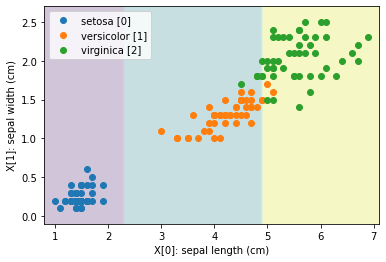

In [18]:
plotDecisao(Arvore(), X, y)

In [19]:
def melhorValor(x, y):
    result = None
    menorImpureza = float('inf')
    xmax = np.max(x)
    xmin = np.min(x)

    while True:
        valor = (xmin+xmax)/2
        impTotal, impMaiores, impMenores = impurezaValor(x, y, valor)
        if impTotal < menorImpureza:
            menorImpureza = impTotal
            result = valor
            if impMenores == 0 or impMenores == 0:
                break
            if impMaiores < impMenores:
                xmin = valor
            else:
                xmax = valor
        else:
            break
    return result, menorImpureza

melhorValor(X[:,0], y)

(2.475, 0.3333333333333333)

In [20]:
def melhorCaracteristica(X, y):
    impurezas = []
    valores = []
    for caracteristica in range(X.shape[1]):
        valor, imp = melhorValor(X[:,caracteristica], y)
        impurezas.append(imp)
        valores.append(valor)
    impurezas = np.array(impurezas)
    caracteristica = np.argmin(impurezas)
    return caracteristica, valores[caracteristica], impurezas[caracteristica]

print(melhorCaracteristica(X,y))

(0, 2.475, 0.3333333333333333)


In [21]:
from sklearn.metrics import accuracy_score
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin

def maisFrequente(y):
    return Counter(y.flat).most_common(1)[0][0]

class Arvore(BaseEstimator, ClassifierMixin):

    def fit(self, X, y):
        self.caracteristica, self.valor, self.imp = melhorCaracteristica(X,y)
        maiores = X[:,self.caracteristica] > self.valor
        if sum(maiores>0) and sum(~maiores)>0:
            self.maiores = Arvore()
            self.maiores.fit(X[maiores,:],y[maiores])
            self.menores = Arvore()
            self.menores.fit(X[~maiores,:],y[~maiores])
        else:
            self.resposta = maisFrequente(y)

    def predict(self, X):
        y = np.empty((X.shape[0]))
        if hasattr(self, 'resposta'):
            y[:] = self.resposta
        else:
            maiores = X[:,self.caracteristica] > self.valor
            y[maiores] = self.maiores.predict(X[maiores,:])
            y[~maiores] = self.menores.predict(X[~maiores,:])
        return y

modelo = Arvore()
modelo.fit(X,y)
ypred = modelo.predict(X)

accuracy_score(y, ypred), (ypred == y)

(0.9933333333333333,
 array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,

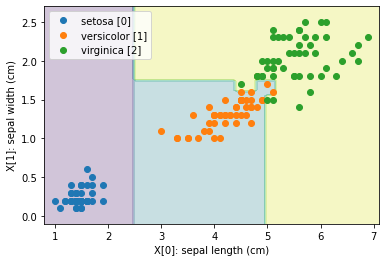

In [22]:
plotDecisao(Arvore(), X, y)

In [23]:
from sklearn.model_selection import cross_validate

scores = cross_validate(Arvore(), X, y)
scores['test_score'], np.mean(scores['test_score'])

(array([0.96666667, 0.96666667, 0.9       , 0.93333333, 1.        ]),
 0.9533333333333334)